In [ ]:
import xml.etree.ElementTree as ET
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.collections import LineCollection

# Define the custom colormap
colors = [(1, 0, 0), (1, 1, 0), (0, 0.8, 0), (0, 0.3, 0)]
green_to_red = LinearSegmentedColormap.from_list('GreenToRed', colors, N=256)

# Parse XML data
tree = ET.parse('output_fcd.xml')  # Replace with your file path
root = tree.getroot()
ring_length = 1000.0
vehicles = {}

for timestep in root.findall('timestep'):
    time = float(timestep.get('time'))
    for vehicle in timestep.findall('vehicle'):
        vid = vehicle.get('id')
        lane = vehicle.get('lane')
        pos = float(vehicle.get('pos'))
        speed = float(vehicle.get('speed'))
        if lane == 'a_0':
            ring_pos = pos
        elif lane == 'b_0':
            ring_pos = 901.53 + pos
        elif lane == ':8/1_0_0':
            ring_pos = 901.53 + pos
        elif lane == ':9/1_0_0':
            ring_pos = 901.53 + 99.23 + pos
        else:
            continue
        ring_pos = min(ring_pos, ring_length)
        if vid not in vehicles:
            vehicles[vid] = {'laps': [[]]}
        current_lap = vehicles[vid]['laps'][-1]
        if current_lap:
            prev_ring_pos = current_lap[-1][1]
            if prev_ring_pos > ring_length - 100 and ring_pos < 100:
                vehicles[vid]['laps'].append([(time, ring_pos, speed)])
            else:
                current_lap.append((time, ring_pos, speed))
        else:
            current_lap.append((time, ring_pos, speed))

# Collect segments and speeds for colored plot
all_segments = []
all_speeds = []
for vid, data in vehicles.items():
    for lap in data['laps']:
        if len(lap) < 2:
            continue
        for i in range(len(lap) - 1):
            t1, p1, s1 = lap[i]
            t2, p2, s2 = lap[i + 1]
            segment = np.array([[t1, p1], [t2, p2]])
            all_segments.append(segment)
            all_speeds.append(s1)

# PLOT 1: Vehicle trajectories with different colors per vehicle
plt.figure(figsize=(25, 6), dpi=300)

# Assign distinct colors to each vehicle using the hsv colormap
num_vehicles = len(vehicles)
vehicle_colors = plt.cm.jet(np.linspace(0, 1, num_vehicles))

# Prepare segments for LineCollection for first plot
all_segments_by_vehicle = []
vehicle_indices = []
for idx, (vid, data) in enumerate(vehicles.items()):
    for lap in data['laps']:
        if len(lap) < 2:
            continue
        points = np.array([(t, p) for t, p, s in lap])
        points = points.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)
        all_segments_by_vehicle.extend(segments)
        vehicle_indices.extend([idx] * len(segments))

# Create LineCollection with distinct colors per vehicle
lc_vehicle = LineCollection(all_segments_by_vehicle, colors=[vehicle_colors[i] for i in vehicle_indices], linewidth=1)

# Add to plot
ax = plt.gca()
ax.add_collection(lc_vehicle)
plt.xlabel('Time (s)')
plt.ylabel('Position on Ring Road (m)')
plt.xlim(0, 600)
plt.ylim(0, 1000)
plt.title('Time-Space Diagram of Vehicle Trajectories')
# Set background to black
ax.set_facecolor('black')
# Adjust grid color for visibility
plt.grid(True, color='white')
plt.tight_layout()
plt.savefig('time_space_diagram(modified).png', dpi=300)
plt.show()
plt.close()

# PLOT 2: Speed-colored trajectories
# Increase DPI for vibrant colors and set figure size
fig, ax = plt.subplots(figsize=(25, 6), dpi=300)

# Create LineCollection with speed-based coloring
lc_speed = LineCollection(all_segments, cmap=green_to_red, norm=plt.Normalize(0, 30))
lc_speed.set_array(np.array(all_speeds))
lc_speed.set_linewidth(1)

ax.add_collection(lc_speed)

# Find max time value
max_time = max([t for data in vehicles.values() for lap in data['laps'] for t, _, _ in lap] or [600])
ax.set_xlim(0, 600)
ax.set_ylim(0, ring_length)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Position on Ring Road (m)')
ax.set_title('Time-Space Diagram with Speed-Colored Trajectories')

# Set background to black
ax.set_facecolor('black')

# Adjust grid color for visibility
ax.grid(True, color='white')

# Add colorbar
cbar = fig.colorbar(lc_speed, ax=ax)
cbar.set_label('Speed (m/s)')

plt.tight_layout()
plt.savefig('time_space_diagram_with_speed(modified).png', dpi=300)
plt.show()
plt.close()


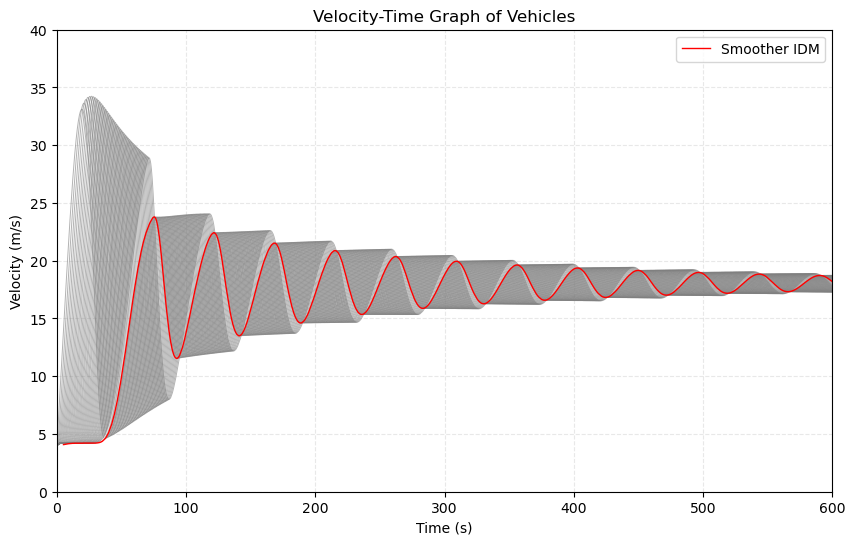

In [2]:
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt

# Parse the FCD output file
tree = ET.parse('output_fcd.xml')
root = tree.getroot()

# Dictionary to store time and speed data for each vehicle
vehicles = {}
for timestep in root.findall('timestep'):
    time = float(timestep.get('time'))
    for vehicle in timestep.findall('vehicle'):
        veh_id = vehicle.get('id')
        speed = float(vehicle.get('speed'))
        if veh_id not in vehicles:
            vehicles[veh_id] = {'time': [], 'speed': []}
        vehicles[veh_id]['time'].append(time)
        vehicles[veh_id]['speed'].append(speed)

# Identify the "smoother" IDM vehicle (assumed to be "veh0" for this example)
smoother_id = "av_0"  # Adjust this based on your simulation data

# Create the velocity-time graph
plt.figure(figsize=(10, 6))

# Plot velocities of all other vehicles in light grey
for veh_id, data in vehicles.items():
    if veh_id != smoother_id:
        plt.plot(data['time'], data['speed'], color='grey', alpha=0.6, linewidth=0.7)

# Plot the "smoother" IDM vehicle in red
if smoother_id in vehicles:
    plt.plot(vehicles[smoother_id]['time'], vehicles[smoother_id]['speed'], 
             color='red', linewidth=1, label='Smoother IDM')

# Set axis labels and title
plt.xlabel('Time (s)')
plt.ylabel('Velocity (m/s)')
plt.title('Velocity-Time Graph of Vehicles')

# Set axis limits to match Image 3
plt.xlim(0, 600)
plt.ylim(0, 40)

# Add grid for readability
plt.grid(True, color='lightgrey', linestyle='--', alpha=0.5)

# Add legend
plt.legend()
plt.savefig('velocity-time graph.png', dpi=300)
# Display the plot
plt.show()

  Interval  Time (s)  Velocity st. dev. (m/s)  Flow (veh/hr)  \
0                  0                     7.03           2572   
1                100                     3.30           3186   
2                200                     1.98           3225   
3                300                     1.29           3237   
4                400                     0.87           3242   
5                500                     0.61           3245   

   Density (veh/km)  Avg Velocity (km/hr)  
0              49.7                 51.58  
1              50.0                 63.76  
2              50.0                 64.55  
3              50.0                 64.79  
4              50.0                 64.89  
5              50.0                 64.95  


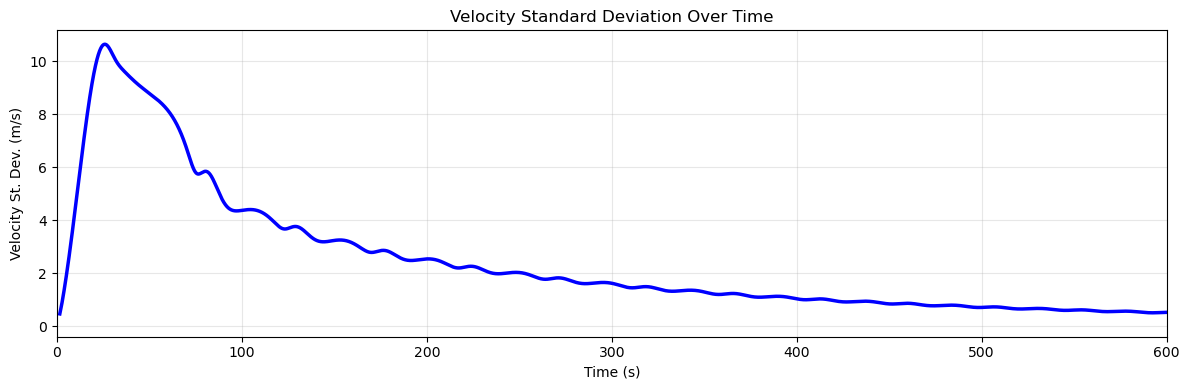

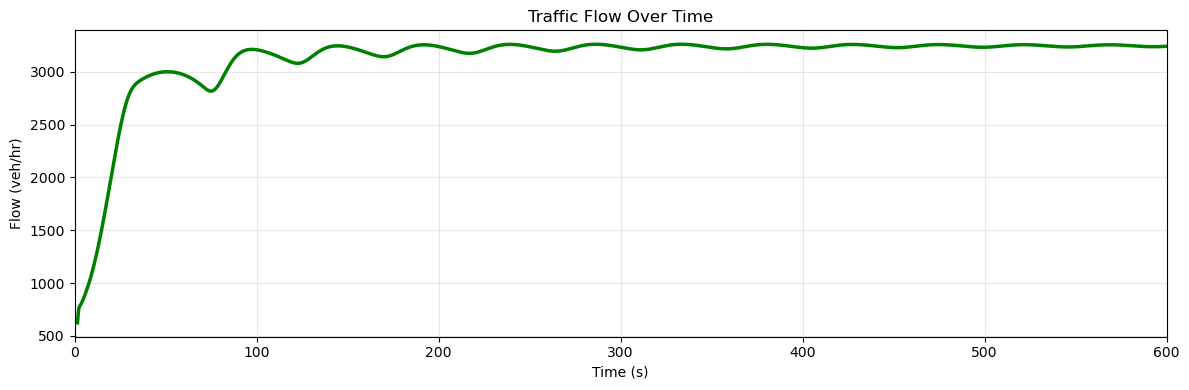

In [1]:
import xml.etree.ElementTree as ET
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def calculate_traffic_metrics(fcd_file, ring_length=1000.76):
    """
    Calculate traffic metrics from SUMO FCD output file
    
    Parameters:
    -----------
    fcd_file : str
        Path to the SUMO FCD output XML file
    ring_length : float
        Length of the ring road in meters
    
    Returns:
    --------
    DataFrame with time, velocity standard deviation, and flow
    """
    # Parse XML file
    tree = ET.parse(fcd_file)
    root = tree.getroot()
    
    # Prepare data storage
    results = []
    
    # Process each timestep
    for timestep in root.findall('timestep'):
        time = float(timestep.get('time'))
        vehicles = timestep.findall('vehicle')
        
        # Skip timesteps with no vehicles
        if not vehicles:
            continue
        
        # Extract velocities for all vehicles at this timestep
        velocities = [float(vehicle.get('speed')) for vehicle in vehicles]
        
        # Calculate velocity standard deviation
        vel_std_dev = np.std(velocities) if len(velocities) > 1 else 0
        
        # Calculate flow (vehicles/hour)
        # Flow = density * average velocity
        # density = number of vehicles / ring length (km)
        num_vehicles = len(vehicles)
        avg_velocity = np.mean(velocities) * 3.6
        density = num_vehicles / (ring_length / 1000)  # veh/km
        flow = density * avg_velocity
        
        # Store results
        results.append({
            'time': time,
            'velocity_std_dev': vel_std_dev,
            'flow': flow,
            'num_vehicles': num_vehicles,
            'avg_velocity': avg_velocity,
            'density': density
        })
    
    # Convert to DataFrame
    df = pd.DataFrame(results)
    
    return df

def plot_metrics(df, window_size=30):
    """
    Plot time-series of velocity standard deviation and flow as line graphs
    
    Parameters:
    -----------
    df : DataFrame
        DataFrame with traffic metrics
    window_size : int
        Window size for moving average smoothing
    """
    # Create first figure for velocity standard deviation
    fig1, ax1 = plt.subplots(1, 1, figsize=(12, 4))
    
    # Plot only smoothed line for velocity std dev
    ax1.plot(df['time'], df['velocity_std_dev'].rolling(window=window_size, center=True).mean(), 
             color='blue', linewidth=2.5)
    ax1.set_ylabel('Velocity St. Dev. (m/s)')
    ax1.set_xlabel('Time (s)')
    ax1.grid(True, alpha=0.3)
    ax1.set_xlim(0, 600)
    ax1.set_title('Velocity Standard Deviation Over Time')
    plt.tight_layout()
    plt.savefig('velocity_std_dev(modified).png', dpi=300)
    plt.show()
    
    # Create second figure for flow
    fig2, ax2 = plt.subplots(1, 1, figsize=(12, 4))
    
    # Plot only smoothed line for flow
    ax2.plot(df['time'], df['flow'].rolling(window=window_size, center=True).mean(), 
             color='green', linewidth=2.5)
    ax2.set_xlabel('Time (s)')
    ax2.set_ylabel('Flow (veh/hr)')
    ax2.grid(True, alpha=0.3)
    ax2.set_xlim(0, 600)
    ax2.set_title('Traffic Flow Over Time')
    plt.tight_layout()
    plt.savefig('flow_line(modified).png', dpi=300)
    plt.show()



def analyze_intervals(df, intervals):
    """
    Analyze metrics for specific time intervals
    
    Parameters:
    -----------
    df : DataFrame
        DataFrame with traffic metrics
    intervals : list of dict
        List of dictionaries with 'start', 'end', and 'name' for each interval
    
    Returns:
    --------
    DataFrame with summarized metrics for each interval
    """
    results = []
    
    for interval in intervals:
        start = interval['start']
        end = interval['end']
        name = interval['name']
        
        # Filter data for this interval
        interval_data = df[(df['time'] >= start) & (df['time'] < end)]
        
        if len(interval_data) == 0:
            continue
        
        # Calculate average metrics for the interval
        avg_vel_std = interval_data['velocity_std_dev'].mean()
        avg_flow = interval_data['flow'].mean()
        avg_density = interval_data['density'].mean()
        avg_velocity = interval_data['avg_velocity'].mean()
        
        results.append({
            'Interval': name,
            'Time (s)': start,
            'Velocity st. dev. (m/s)': round(avg_vel_std, 2),
            'Flow (veh/hr)': round(avg_flow),
            'Density (veh/km)': round(avg_density, 1),
            'Avg Velocity (km/hr)': round(interval_data['avg_velocity'].mean(), 2),
        })
    
    
    return pd.DataFrame(results)

# Example usage
if __name__ == "__main__":
    # Replace with your FCD file path
    fcd_file = "output_fcd.xml"
    
    # Calculate metrics
    metrics_df = calculate_traffic_metrics(fcd_file)
    
    # Define intervals for analysis
    intervals = [
        {'start': 0, 'end': 100, 'name': ''},
        {'start': 100, 'end': 200, 'name': ''},
        {'start': 200, 'end': 300, 'name': ''},
        {'start': 300, 'end': 400, 'name': ''},
        {'start': 400, 'end': 500, 'name': ''},
        {'start': 500, 'end': 600, 'name': ''},
    ]
    
    # Analyze intervals
    summary_df = analyze_intervals(metrics_df, intervals)
    
    # Print summary table
    print(summary_df)
    
    # Plot metrics
    plot_metrics(metrics_df)